# **Install libraries**

In [1]:
#This is for running googel collab
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


Install necessary libraries: pmdarima, neuralprophet and holidays

In [2]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 5.3 MB/s 
     |████████████████████████████████| 9.8 MB 44.7 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [3]:
!pip install neuralprophet

     |████████████████████████████████| 67 kB 3.1 MB/s 
     |████████████████████████████████| 165 kB 11.2 MB/s 
  Attempting uninstall: holidays
    Found existing installation: holidays 0.10.5.2
    Uninstalling holidays-0.10.5.2:
      Successfully uninstalled holidays-0.10.5.2


In [4]:
!pip install holidays

# **Load libraries**

In [5]:
#imports
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns  
import datetime as dt
from scipy import stats
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from sklearn.metrics import mean_squared_error
import plotly as py

%matplotlib inline
import math
import random
from datetime import timedelta

import calendar

import holidays

import fbprophet
from fbprophet import Prophet

from neuralprophet import NeuralProphet

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings 
warnings.filterwarnings('ignore')

seed=42
#color pallette
cnf = '#393e46'
dth = 'ff2e63'
rec = '#21bf73'
act = '#fe9801'
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=14, titlepad=10)

# **Dataset Source & Info**

In [ ]:
#This will automatically retrvie the latest version of the dataset
df=pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv',encoding='utf-8')
df

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,0.126,0.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152230,ZWE,Africa,Zimbabwe,2021-12-31,213258.0,1530.0,1503.143,5004.0,7.0,19.000,14130.373,101.377,99.598,331.563,0.464,1.259,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6152.0,1707232.0,113.120,0.408,5259.0,0.348,0.2858,3.5,tests performed,7259546.0,4124378.0,3135168.0,NaN,NaN,8396.0,48.10,27.33,20.77,NaN,556.0,4099.0,0.027,NaN,15092171.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
152231,ZWE,Africa,Zimbabwe,2022-01-01,214214.0,956.0,1495.429,5017.0,13.0,18.857,14193.717,63.344,99.086,332.424,0.861,1.249,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3593.0,1710825.0,113.358,0.238,5358.0,0.355,0.2791,3.6,tests performed,7270566.0,4130228.0,3140338.0,NaN,11020.0,8788

In [ ]:
#This needs to be upadate to new path on the runnig local dirve
f1 = pd.read_csv('/content/drive/MyDrive/covid_19_data_cleaned.csv', parse_dates = ['Date'])

country_daywise = pd.read_csv('/content/drive/MyDrive/country_daywise.csv', parse_dates = ['Date'])
countrywise = pd.read_csv('/content/drive/MyDrive/countrywise.csv')
daywise = pd.read_csv('/content/drive/MyDrive/daywise.csv', parse_dates = ['Date'])


#**Data Cleaning And Preparation**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152235 entries, 0 to 152234
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    152235 non-null  object 
 1   continent                                   143059 non-null  object 
 2   location                                    152235 non-null  object 
 3   date                                        152235 non-null  object 
 4   total_cases                                 149610 non-null  float64
 5   new_cases                                   149586 non-null  float64
 6   new_cases_smoothed                          148435 non-null  float64
 7   total_deaths                                132419 non-null  float64
 8   new_deaths                                  132604 non-null  float64
 9   new_deaths_smoothed                         132472 non-null  float64
 

In [ ]:
#select columns for analysis

df=df.loc[:,['iso_code', 'continent', 'location', 'date', 
          'total_cases', 'new_cases', 'total_deaths', 'new_deaths',
          'icu_patients','hosp_patients', 
          'new_tests', 'total_tests',
          'total_vaccinations','people_vaccinated', 'people_fully_vaccinated','new_vaccinations','population']
      ]

#Confirmed cases ['total_cases', 'new_cases']
#Confirmed deaths['total_deaths', 'new_deaths']
#Hospital & ICU ['icu_patients','hosp_patients']
#Tests & positivity ['new_tests', 'total_tests','positive_rate']
#Vaccinations ['total_vaccinations','people_vaccinated', 'people_fully_vaccinated','new_vaccinations']
#Others ['iso_code', 'continent', 'location', 'date','population']

In [ ]:
#set date as datetime
df.date=df.date.astype(np.datetime64)

In [ ]:
#Check missing values
df.isna().sum().sort_values(ascending=False)

icu_patients               133656
hosp_patients              131844
new_vaccinations           119890
people_fully_vaccinated    117732
people_vaccinated          114845
total_vaccinations         113218
new_tests                   91847
total_tests                 90463
total_deaths                19816
new_deaths                  19631
continent                    9176
new_cases                    2649
total_cases                  2625
population                   1015
location                        0
date                            0
iso_code                        0
dtype: int64

In [ ]:
df[df.continent.isna()].location.unique()

array(['Africa', 'Asia', 'Europe', 'European Union', 'High income',
       'International', 'Low income', 'Lower middle income',
       'North America', 'Oceania', 'South America', 'Upper middle income',
       'World'], dtype=object)

In [ ]:
#fill continent NAN with corresponded location values
df['continent']=df['continent'].fillna(df['location'])

Find out what countries missing population **data**

In [ ]:
#find out what countries missing population data
df[df.population.isna()].location.unique()

array(['International', 'Northern Cyprus'], dtype=object)

In [ ]:
df.groupby('location')['population'].get_group('Northern Cyprus').sum()

0.0

In [ ]:
df.groupby('location')['population'].get_group('International').sum()

0.0

Both of International, Northern Cyprus show population of 0 and most of data is missing.
So we will drop both International, Northern Cyprus data.

In [ ]:
df[df.location.str.contains('Northern Cyprus')].info()
df[df.location.str.contains('Northern Cyprus')].isna().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 317 entries, 103164 to 103480
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   iso_code                 317 non-null    object        
 1   continent                317 non-null    object        
 2   location                 317 non-null    object        
 3   date                     317 non-null    datetime64[ns]
 4   total_cases              0 non-null      float64       
 5   new_cases                0 non-null      float64       
 6   total_deaths             0 non-null      float64       
 7   new_deaths               0 non-null      float64       
 8   icu_patients             0 non-null      float64       
 9   hosp_patients            0 non-null      float64       
 10  new_tests                0 non-null      float64       
 11  total_tests              0 non-null      float64       
 12  total_vaccinations       26 

iso_code                     0
continent                    0
location                     0
date                         0
total_cases                317
new_cases                  317
total_deaths               317
new_deaths                 317
icu_patients               317
hosp_patients              317
new_tests                  317
total_tests                317
total_vaccinations         291
people_vaccinated          294
people_fully_vaccinated    294
new_vaccinations           315
population                 317
dtype: int64

In [ ]:
df.population = df.population.dropna()

In [ ]:
df=df.dropna(subset=['population'])

**Dealing with the NaN data**


1.   For cumulative data --> group by location, fill nan with ffill method first then fill the rest with 0: `total_cases`, `total_deaths`, `total_tests`, `tests_units`, `total_vaccinations`, `people_vaccinated`, `people_fully_vaccinated`,`icu_patients`, `hosp_patients`
2.   For non-cumulative data --> fill nan with the difference b/t 2 rows `new_cases`, `new_deaths`,`new_tests`,`new_vaccinations`


In [ ]:
 #For cumulative data --> ffill then fillna(0)
 df[['total_cases', 'total_deaths', 'icu_patients','hosp_patients','total_tests','total_vaccinations','people_vaccinated', 'people_fully_vaccinated']]= \
 df.groupby('location')[['total_cases', 'total_deaths', 'icu_patients','hosp_patients','total_tests','total_vaccinations','people_vaccinated', 'people_fully_vaccinated']]\
 .fillna(method='ffill').fillna(0)

In [ ]:
df.new_cases=df.groupby('location')['new_cases'].fillna(df.groupby('location')['total_cases'].diff(periods=1)).fillna(0)
df.new_deaths=df.groupby('location')['new_deaths'].fillna(df.groupby('location')['total_deaths'].diff(periods=1)).fillna(0)
df.new_tests=df.groupby('location')['new_tests'].fillna(df.groupby('location')['total_tests'].diff(periods=1)).fillna(0)
df.new_vaccinations=df.groupby('location')['new_vaccinations'].fillna(df.groupby('location')['total_vaccinations'].diff(periods=1)).fillna(0)
df1['Province/State'] = df1['Province/State'].fillna("")

In [ ]:
confirmed = df1.groupby('Date').sum()['Confirmed'].reset_index()
recovered = df1.groupby('Date').sum()['Recovered'].reset_index()
deaths = df1.groupby('Date').sum()['Deaths'].reset_index()

In [ ]:
df1.isnull().sum()

Date              0
Province/State    0
Country           0
Lat               0
Long              0
Confirmed         0
Recovered         0
Deaths            0
Active            0
dtype: int64

In [ ]:
df.isna().sum().sort_values(ascending=False)

population                 0
new_deaths                 0
continent                  0
location                   0
date                       0
total_cases                0
new_cases                  0
total_deaths               0
icu_patients               0
new_vaccinations           0
hosp_patients              0
new_tests                  0
total_tests                0
total_vaccinations         0
people_vaccinated          0
people_fully_vaccinated    0
iso_code                   0
dtype: int64

In [ ]:
df1.query('Country == "US"')

,Date,Province/State,Country,Lat,Long,Confirmed,Recovered,Deaths,Active
180030,2020-01-22,,US,40.0,-100.0,1,0,0,1
180031,2020-01-23,,US,40.0,-100.0,1,0,0,1
180032,2020-01-24,,US,40.0,-100.0,2,0,0,2
180033,2020-01-25,,US,40.0,-100.0,2,0,0,2
180034,2020-01-26,,US,40.0,-100.0,5,0,0,5
...,...,...,...,...,...,...,...,...,...
180731,2021-12-23,,US,40.0,-100.0,51814820,0,815423,50999397
180732,2021-12-24,,US,40.0,-100.0,52041953,0,816436,51225517
180733,2021-12-25,,US,40.0,-100.0,52098906,0,816533,51282373
180734,2021-12-26,,US,40.0,-100.0,52280854,0,816609,51464245


**Checking duplicates**

In [ ]:
df.duplicated().sum()
#no duplicates found

0

In [ ]:
df.head()

,iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,icu_patients,hosp_patients,new_tests,total_tests,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,population
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39835428.0
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39835428.0
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39835428.0
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39835428.0
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39835428.0


In [ ]:
#set numberformatting
pd.options.display.float_format = '{:,.2f}'.format

In [ ]:
df1.head()

,Date,Province/State,Country,Lat,Long,Confirmed,Recovered,Deaths,Active
0,2020-01-22,,Afghanistan,33.94,67.71,0,0,0,0
1,2020-01-23,,Afghanistan,33.94,67.71,0,0,0,0
2,2020-01-24,,Afghanistan,33.94,67.71,0,0,0,0
3,2020-01-25,,Afghanistan,33.94,67.71,0,0,0,0
4,2020-01-26,,Afghanistan,33.94,67.71,0,0,0,0


In [ ]:
world_comparasion=df.groupby('location')['continent','total_cases','total_deaths','people_vaccinated','population'].max().sort_values(by='location',ascending=False).reset_index()
world_comparasion['percent_population_vaccinated']=world_comparasion['people_vaccinated']/world_comparasion['population']
world_comparasion['percent_population_death']=world_comparasion['total_deaths']/world_comparasion['population']
world_comparasion= world_comparasion.loc[world_comparasion['location'] != world_comparasion['continent']].reset_index(drop=True)
world_comparasion

,location,continent,total_cases,total_deaths,people_vaccinated,population,percent_population_vaccinated,percent_population_death
0,Zimbabwe,Africa,"217,678.00","5,078.00","4,141,434.00","15,092,171.00",0.27,0.00
1,Zambia,Africa,"265,479.00","3,762.00","806,611.00","18,920,657.00",0.04,0.00
2,Yemen,Asia,"10,143.00","1,984.00","556,652.00","30,490,639.00",0.02,0.00
3,Wallis and Futuna,Oceania,454.00,7.00,"6,016.00","11,094.00",0.54,0.00
4,Vietnam,Asia,"1,800,704.00","33,245.00","77,850,611.00","98,168,829.00",0.79,0.00
...,...,...,...,...,...,...,...,...
219,Angola,Africa,"84,666.00","1,778.00","7,685,417.00","33,933,611.00",0.23,0.00
220,Andorra,Europe,"24,802.00",141.00,"56,628.00","77,354.00",0.73,0.00
221,Algeria,Africa,"219,953.00","6,303.00","7,060,737.00","44,616,626.00",0.16,0.00
222,Albania,Europe,"212,021.00","3,224.00","1,141,486.00","2,872,934.00",0.40,0.00


# **Data Visualizations And Understanding**

## **Line Plot**

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=confirmed['Date'], y=confirmed['Confirmed'], name='Confirmed', mode='lines+markers', line = dict(color="Orange", width=2)))
fig.add_trace(go.Scatter(x=recovered['Date'], y=recovered['Recovered'], name='Recovered', mode='lines+markers', line = dict(color="Green", width=2)))
fig.add_trace(go.Scatter(x=deaths['Date'], y=deaths['Deaths'], name='Deaths', mode='lines+markers', line = dict(color="Red", width=2)))
fig.update_layout(title='Covid-19 Cases', xaxis_title='Date', yaxis_title='Number of Cases', font=dict(family='Courier New, monospace', size=18, color='Black'))

In [ ]:
#Changing date colom from datetime64 to str
df1['Date'] = df1['Date'].astype(str)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201916 entries, 0 to 201915
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Date            201916 non-null  object 
 1   Province/State  201916 non-null  object 
 2   Country         201916 non-null  object 
 3   Lat             201916 non-null  float64
 4   Long            201916 non-null  float64
 5   Confirmed       201916 non-null  int64  
 6   Recovered       201916 non-null  int64  
 7   Deaths          201916 non-null  int64  
 8   Active          201916 non-null  int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 13.9+ MB


##**Confirmed Cases Worldwide With Choropleth Map (log10)**

In [ ]:
fig = px.choropleth(country_daywise, locations="Country",locationmode='country names',color=np.log(country_daywise['Confirmed']),hover_name='Country',animation_frame=country_daywise['Date'].dt.strftime('%Y-%m-%d'),title='Covid-19 Cases in the World',color_continuous_scale=px.colors.sequential.Inferno)
fig.update(layout_coloraxis_showscale=True)


Output hidden; open in https://colab.research.google.com to view.

##**Scatter Plot For Deaths vs Confirmed Cases**

In [ ]:
top = 15
fig = px.scatter(countrywise.sort_values('Deaths',ascending=False).head(top),
 x='Confirmed', y='Deaths', color='Country',size= 'Confirmed',
 height=700,text='Country', log_x = True, log_y = True,
   title='Top 15 Countries with the most Deaths')
#fig.uptade_traces(textposition='top center')
fig.update_layout(showlegend=True)
fig.update_layout(xaxis_rangeslider_visible=True)
fig.show()

##**Cases over the time With Area plot**

In [ ]:
temp = df1.groupby('Date')['Recovered','Deaths','Active'].sum().reset_index()
temp = temp.melt(id_vars='Date', value_vars=['Recovered','Deaths','Active'],var_name = 'Case', value_name = 'Count')

fig = px.area(temp,x='Date',y = 'Count',color = 'Case', height = 600, title = 'Cases over time')
fig.update_layout(xaxis_rangeslider_visible=True)
fig.show()


In [ ]:
def plot_daywise(col, hue):
    fig = px.bar(daywise, x="Date", y=col, width=700, color_discrete_sequence=['red'])
    fig.update_layout(title=col, xaxis_title="", yaxis_title="")
    fig.show()


In [ ]:
def plot_daywise_line(col, hue):
    fig = px.line(daywise, x="Date", y=col, width=700, color_discrete_sequence=['red'])
    fig.update_layout(title=col, xaxis_title="", yaxis_title="")
    fig.show()

In [ ]:
plot_daywise('Confirmed', '#333333')


In [ ]:
plot_daywise('New Cases', '#333333')

In [ ]:
plot_daywise('Deaths', dth)

In [ ]:
plot_daywise_line('Deaths / 100 Cases', dth)

In [ ]:
plot_daywise_line('Deaths / 100 Recovered', dth)

In [ ]:
plot_daywise_line('Recovered / 100 Cases', rec)

# **World Comparasion**

**The top 15 countries (population > 10 million) have the most COVID cases.**

In [ ]:
country_pop_more_than_10m= world_comparasion[world_comparasion['population']>10000000]

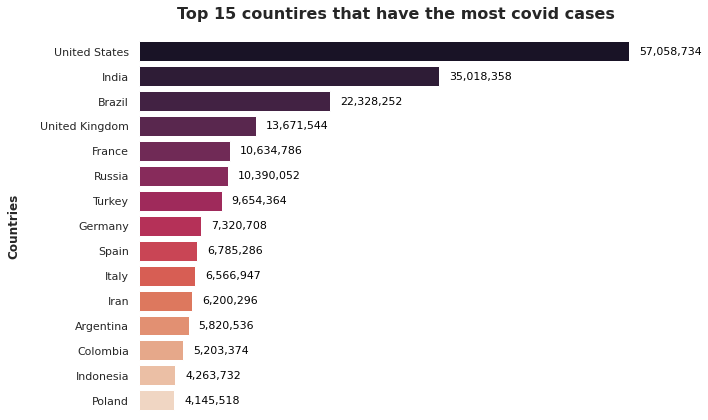

In [ ]:
# 1. Top 15 countries (population > 10 millons) have the most covid cases
top_15_total_cases = country_pop_more_than_10m[['location','population','total_cases']].sort_values(by='total_cases',ascending=False).reset_index(drop=True).head(15)

sns.set_theme(style='white')
f, ax = plt.subplots(figsize=(10, 6))
ax= sns.barplot(x='total_cases' , y='location', data=top_15_total_cases, palette='rocket')
sns.despine(left=True, bottom=True)
ax.set(xticklabels=[]) 
ax.tick_params(bottom=False)

ax.axes.set_title('Top 15 countires that have the most covid cases',fontsize=16, pad=20)
ax.set_xlabel('')
ax.set_ylabel('Countries',fontsize=12, labelpad=20)

#set annotation
for p in ax.patches:
    ax.annotate('{:,}'.format(int(p.get_width())), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(10, 0), textcoords='offset points', ha='left', va='center', color='black', fontsize=11);

**The top 15 European countries (population  > 10 million) have the highest percentage of vaccinated population.**

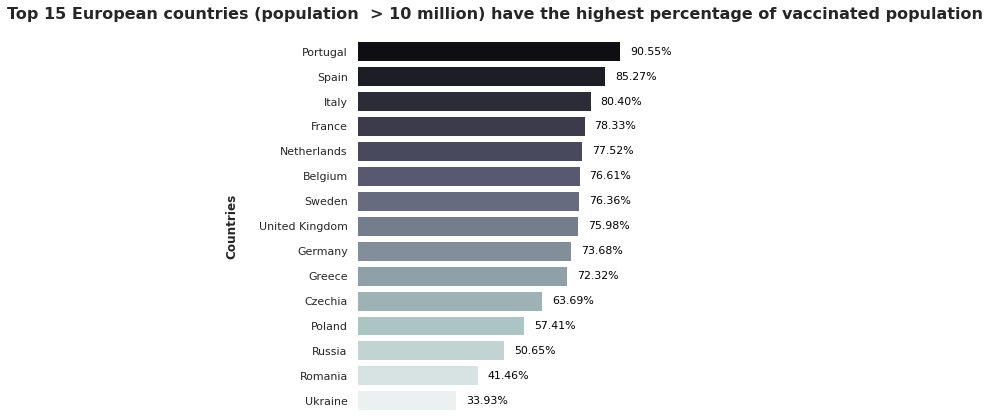

In [ ]:
# 2. The top 15 European countries (with a population of more than 10 million) have the highest percentage of vaccinated citizens.
top_8_percent_population_vaccinated_EU=country_pop_more_than_10m[country_pop_more_than_10m.continent=='Europe'].sort_values(by='percent_population_vaccinated', ascending=False).head(15)

sns.set_theme(style='white')
f, ax = plt.subplots(figsize=(10, 6))
ax= sns.barplot(x='percent_population_vaccinated' , y='location', data=top_8_percent_population_vaccinated_EU, palette='bone')
sns.despine(left=True, bottom=True)
ax.set(xticklabels=[]) 
ax.tick_params(bottom=False)


ax.axes.set_title('Top 15 European countries (population  > 10 million) have the highest percentage of vaccinated population',fontsize=16, pad=20)
ax.set_xlabel('')
ax.set_ylabel('Countries',fontsize=12, labelpad=20)

#set annotation
for p in ax.patches:
    ax.annotate('{:,.2f}%'.format(float(p.get_width())*100), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(10, 0), textcoords='offset points', ha='left', va='center', color='black', fontsize=11);

**The top 15 countries in North America (population > 10 million) have the highest rate of COVID-related population deaths.**

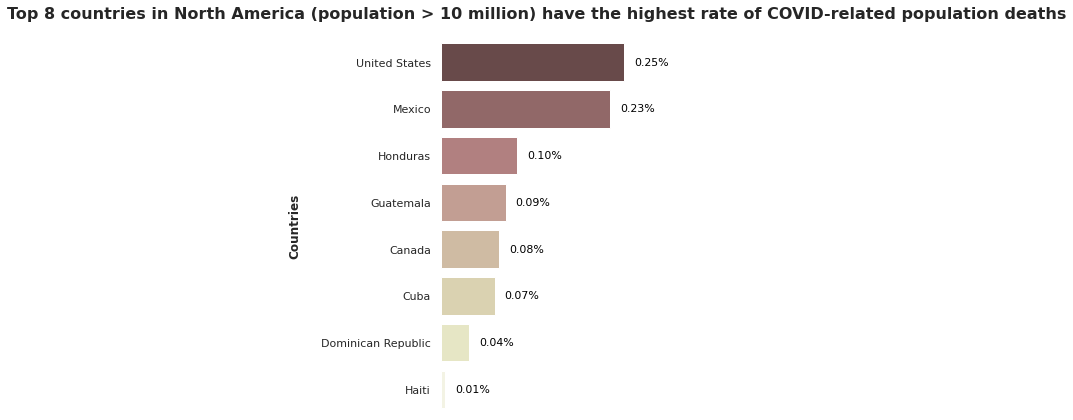

In [ ]:
#3. The top 8 countries in North America (population > 10 million) have the highest rate of COVID-related population deaths.

top_15_percent_population_death_NA=country_pop_more_than_10m[country_pop_more_than_10m.continent=='North America'].sort_values(by='percent_population_death', ascending=False).head(15)


sns.set_theme(style='white')
f, ax = plt.subplots(figsize=(10, 6))
ax= sns.barplot(x='percent_population_death', y='location', data=top_15_percent_population_death_NA, palette='pink')
sns.despine(left=True, bottom=True)
ax.set(xticklabels=[]) 
ax.tick_params(bottom=False)


ax.axes.set_title('Top 8 countries in North America (population > 10 million) have the highest rate of COVID-related population deaths',fontsize=16, pad=20)
ax.set_xlabel('')
ax.set_ylabel('Countries',fontsize=12, labelpad=20)

#set annotation
for p in ax.patches:
    ax.annotate('{:,.2f}%'.format(float(p.get_width())*100), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(10, 0), textcoords='offset points', ha='left', va='center', color='black', fontsize=11);
    

# **Canada Covid Analysis**

In [ ]:
df1.head()

,Date,Province/State,Country,Lat,Long,Confirmed,Recovered,Deaths,Active
0,2020-01-22,,Afghanistan,33.94,67.71,0,0,0,0
1,2020-01-23,,Afghanistan,33.94,67.71,0,0,0,0
2,2020-01-24,,Afghanistan,33.94,67.71,0,0,0,0
3,2020-01-25,,Afghanistan,33.94,67.71,0,0,0,0
4,2020-01-26,,Afghanistan,33.94,67.71,0,0,0,0


## **A quick look**

In [ ]:
Canada_covid=df[df.location == 'Canada']
Canada_covid['percent_population_vaccinated'] = Canada_covid.loc[:,'people_vaccinated']/Canada_covid.loc[:,'population']
Canada_covid.head()

,iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,icu_patients,hosp_patients,new_tests,total_tests,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,population,percent_population_vaccinated
24894,CAN,North America,Canada,2020-01-26,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"38,067,913.00",0.00
24895,CAN,North America,Canada,2020-01-27,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"38,067,913.00",0.00
24896,CAN,North America,Canada,2020-01-28,2.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"38,067,913.00",0.00
24897,CAN,North America,Canada,2020-01-29,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"38,067,913.00",0.00
24898,CAN,North America,Canada,2020-01-30,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"38,067,913.00",0.00


In [ ]:
Canada_covid.iloc[-1].to_frame()[2:]

,25603
location,Canada
date,2022-01-04 00:00:00
total_cases,"2,344,242.00"
new_cases,"83,354.00"
total_deaths,"30,491.00"
new_deaths,62.00
icu_patients,662.00
hosp_patients,"4,059.00"
new_tests,0.00
total_tests,"52,560,743.00"


Get a quick look to see the relationships between the number of icu patients, hospital patients, new deaths, and the percentage of the population vaccinated in Canada. The below heatmap and pairplot shows that new cases are positively related to the number of hospital patients, icu patients, new deaths, and the percentage of the population vaccinated in Canada.

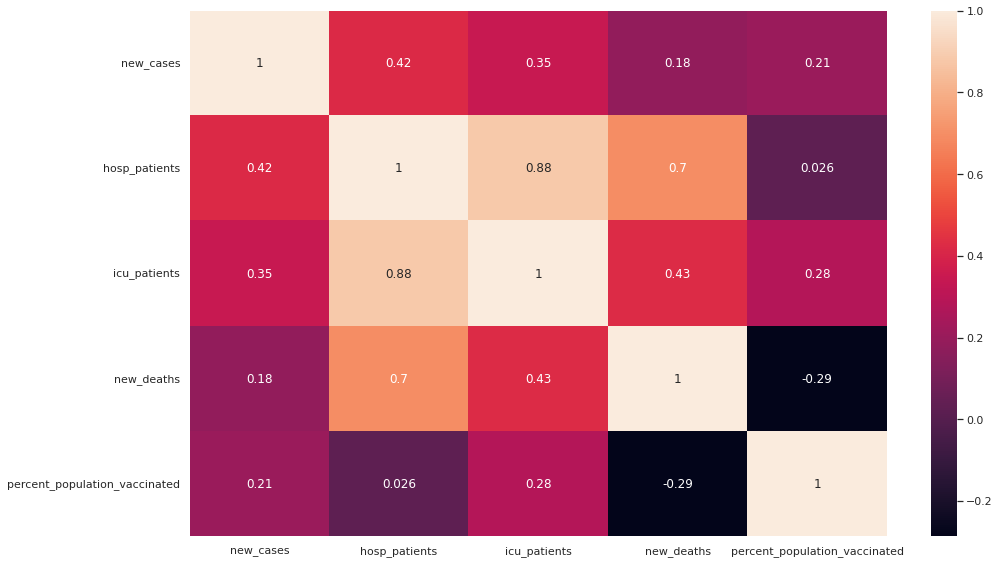

In [ ]:
plt.figure(figsize = (15,8))
sns.heatmap(Canada_covid[['new_cases','hosp_patients','icu_patients','new_deaths','percent_population_vaccinated']].corr(),annot=True)

According to CTV news, the first COVID-19 vaccines administered in Canada is on Dec 14, 2020.

In [ ]:
after_1st_vaccine_date=Canada_covid[Canada_covid.date >'2020-12-14']

In [ ]:
lowest_new_cases = after_1st_vaccine_date[after_1st_vaccine_date.new_cases >1].sort_values(by='new_cases').head(1)
lowest_new_cases_date = lowest_new_cases.date

How does the percentage of the population vaccinated affect new COVID-19 cases in Canada overtime?


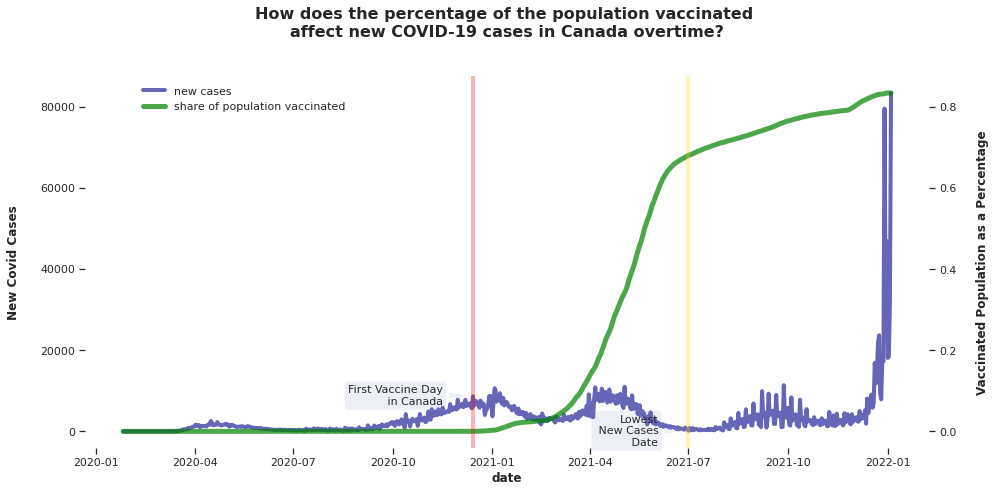

In [ ]:
sns.set_theme(style='ticks')
sns.set_context('notebook')

fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111)
ax.plot(Canada_covid.date, Canada_covid.new_cases, 'darkblue', label = 'new cases', linewidth = 4, alpha= 0.6)

ax2 = ax.twinx()
ax2.plot(Canada_covid.date, Canada_covid.percent_population_vaccinated, 'green', label = 'share of population vaccinated',linewidth = 5, alpha= 0.7)

ax.set_xlabel('date')
ax.set_ylabel(r'New Covid Cases', labelpad=20)
ax2.set_ylabel(r'Vaccinated Population as a Percentage', labelpad=20)


plt.axvline(dt.datetime(2020,12,14), linewidth = 4, color='red',alpha= 0.3);
plt.axvline(lowest_new_cases_date, linewidth = 4, color='gold',alpha= 0.3);

ax.annotate('Lowest\n New Cases\n Date', xy=(lowest_new_cases_date, lowest_new_cases.new_cases),  xycoords='data',
             xytext=(-30, 0), textcoords='offset points',
             size=11, ha='right', va='center',
             bbox=dict(boxstyle='round', alpha=0.1),
             arrowprops=dict(arrowstyle='wedge,tail_width=0.5', alpha=0.1));

ax.annotate('First Vaccine Day\n in Canada', xy=(dt.datetime(2020,12,14), 8800),  xycoords='data',
             xytext=(-30, 0), textcoords='offset points',
             size=11, ha='right', va='center',
             bbox=dict(boxstyle='round', alpha=0.1),
             arrowprops=dict(arrowstyle='wedge,tail_width=0.5', alpha=0.1))

ax.axes.set_title('How does the percentage of the population vaccinated \naffect new COVID-19 cases in Canada overtime?',fontsize=16, weight='bold', pad=40)


sns.despine(left=True, bottom=True)

fig.legend(loc=1, bbox_to_anchor=(0.32,1), bbox_transform=ax.transAxes);

Three specific period Analysis

In 3 different periods according to the above time series analyses, how does the relationship changes between the percentage of the population vaccinated and

the number of Canadian COVID cases

  * the number of Canadian COVID cases
  * the number of COVID-19 related deaths
  * the number of hospital and icu patients

In [ ]:
#set first vacciantion date & lowes new cases date
first_vaccine_datetime = pd.to_datetime('2020-12-14')
lowest_new_cases_datetime = lowest_new_cases_date.item()

##**1) The first period - before the 1st vaccination date in Canada (before 2020-12-14)**

How did the COVID situation in Canada prior to the vaccination program?

In [ ]:
#before the 1st vaccination date
before_1st_vaccine =Canada_covid[Canada_covid.date < first_vaccine_datetime]

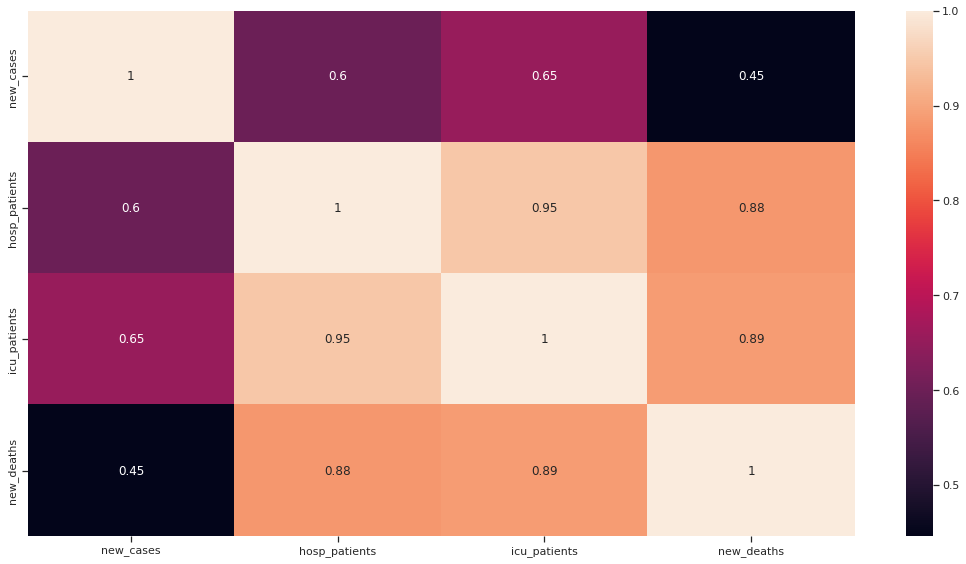

In [ ]:
plt.figure(figsize = (15,8))
sns.heatmap(before_1st_vaccine[['new_cases','hosp_patients','icu_patients','new_deaths']].corr(),annot=True)

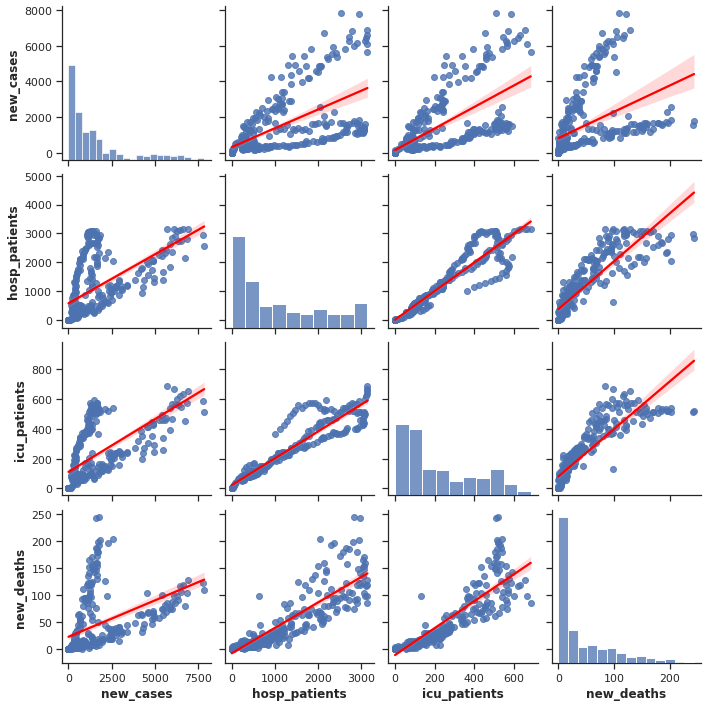

In [ ]:
sns.pairplot(before_1st_vaccine[['new_cases','hosp_patients','icu_patients', 'new_deaths']], kind='reg', plot_kws={'line_kws':{'color':'red'}});

**Insight 1**

We can see that before the first vaccination date in Canada:

* New COVID cases were positively associated with hospital patients (corr = 0.60), icu patients (corr = 0.65), and new deaths (corr = 0.45).
* The number of hospital patients was highly associated with the number of ICU *
*patients (corr = 0.95), and the number of new deaths (corr = 0.88).
The number of ICU patients was highly associated with the number of new deaths (corr = 0.89).

## **2) The second period - between the 1st vaccination date and the date with the lowest number of new cases (2020-12-14 ~ 2021-07-01)**

*Note: At the time this project is being completed the lowest new case date in Canada is 2021-07-01.The time frame may change as real-world scenarios change.*

How did the situation with COVID in Canada between the 1st vaccination date and the date with the lowest number of new cases?

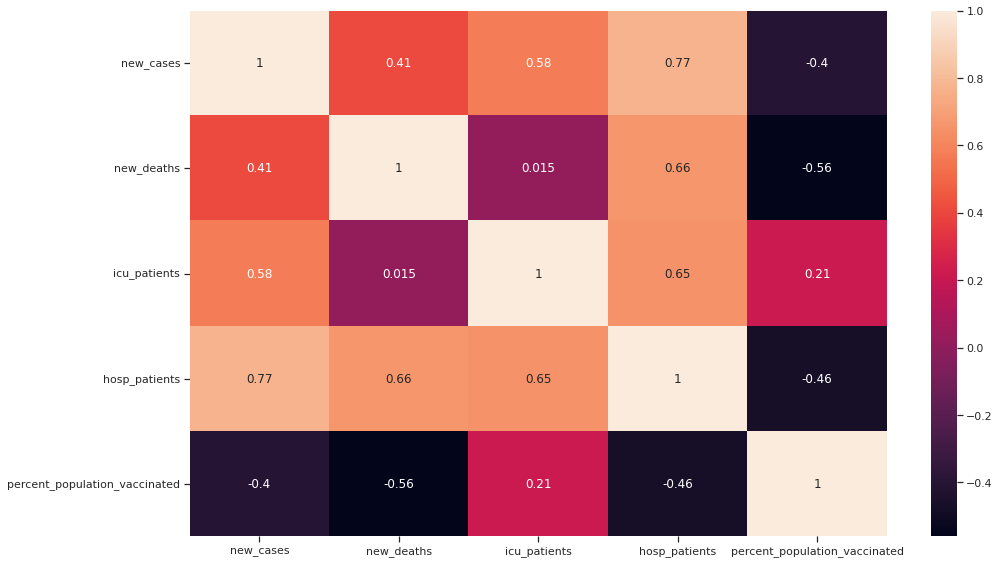

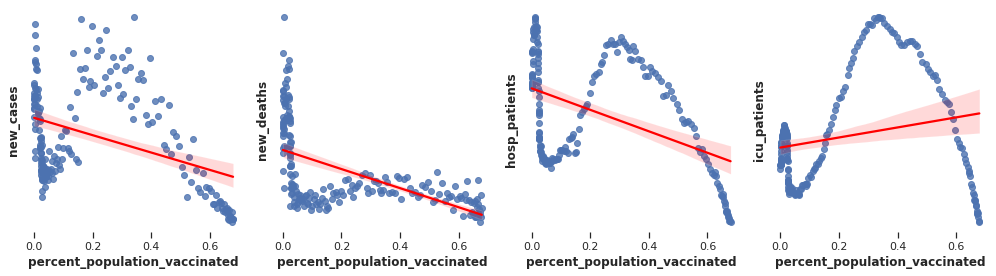

In [ ]:
#b/t the 1st vaccination date and the lowest new cases date
between_1st_and_lowest_new_cases =Canada_covid[(Canada_covid.date > first_vaccine_datetime) & (Canada_covid.date <lowest_new_cases_datetime)]

plt.figure(figsize = (15,8))
sns.heatmap(between_1st_and_lowest_new_cases[['new_cases','new_deaths','icu_patients','hosp_patients','percent_population_vaccinated']].corr(),annot=True)

f, axes = plt.subplots(1,4,figsize=(14, 4), sharex=True)

# Plot a simple distribution of the desired columns
sns.regplot(data=between_1st_and_lowest_new_cases,x='percent_population_vaccinated', y='new_cases', line_kws={'color': 'red'}, ax=axes[0])
sns.regplot(data=between_1st_and_lowest_new_cases,x='percent_population_vaccinated', y='new_deaths', line_kws={'color': 'red'}, ax=axes[1])
sns.regplot(data=between_1st_and_lowest_new_cases,x='percent_population_vaccinated', y='hosp_patients',line_kws={'color': 'red'},ax=axes[2])
sns.regplot(data=between_1st_and_lowest_new_cases,x='percent_population_vaccinated', y='icu_patients', line_kws={'color': 'red'}, ax=axes[3])
sns.despine(left=True, bottom=True)


plt.setp(axes, yticks=[])
plt.tight_layout()

**Insight 2**

We can see that between the 1st vaccination date and the lowest new case date (2020-12-14 ~ 2021-07-01) in Canada, the percentage of the population that got vaccinated is

* negatively associated with the number of new COVID cases (corr= -0.4)
* negatively associated with new deaths (corr= -0.56)
* negatively associated with hospital patients (corr= -0.46)
* However, it does not decrease the number of icu patients (corr=0.21) at this time.

## **3) The third period - after the date with the lowest number of new cases (after 2021-07-01)**

*Note: At the time this project is being completed the lowest new case date in Canada is 2021-07-01.The time frame may change as real-world scenarios change.*

How did the COVID situation in Canada look like after the date with the lowest number of new cases?

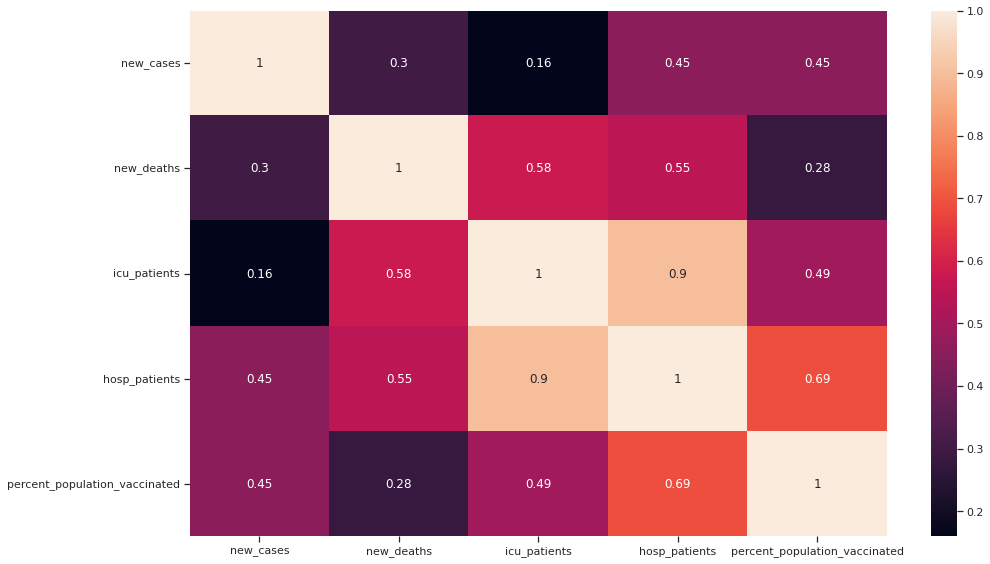

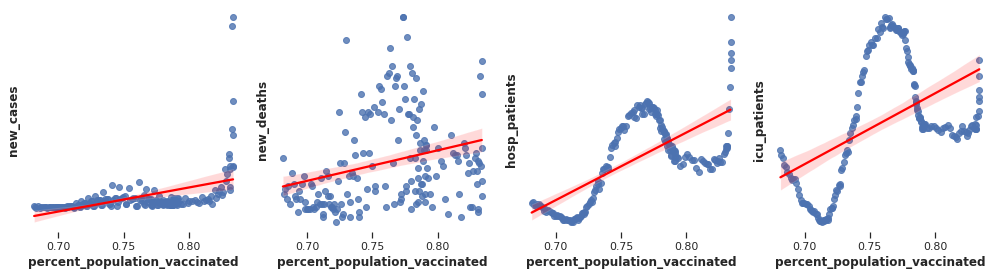

In [ ]:
 #after the lowest new cases date
after_lowest_new_cases = Canada_covid[Canada_covid.date >lowest_new_cases_datetime]

plt.figure(figsize = (15,8))
sns.heatmap(after_lowest_new_cases[['new_cases','new_deaths','icu_patients','hosp_patients','percent_population_vaccinated']].corr(),annot=True)

f, axes = plt.subplots(1,4,figsize=(14, 4), sharex=True)

# Plot a simple distribution of the desired columns
sns.regplot(data=after_lowest_new_cases,x='percent_population_vaccinated', y='new_cases', line_kws={'color': 'red'}, ax=axes[0])
sns.regplot(data=after_lowest_new_cases,x='percent_population_vaccinated', y='new_deaths', line_kws={'color': 'red'}, ax=axes[1])
sns.regplot(data=after_lowest_new_cases,x='percent_population_vaccinated', y='hosp_patients', line_kws={'color': 'red'},ax=axes[2])
sns.regplot(data=after_lowest_new_cases,x='percent_population_vaccinated', y='icu_patients',line_kws={'color': 'red'}, ax=axes[3])
sns.despine(left=True, bottom=True)


plt.setp(axes, yticks=[])
plt.tight_layout()

**Insight 3**

We can see that after the lowest new case date (after 2021-07-01) in Canada, the percentage of the population that got vaccinated is again

* positively associated with the number of new COVID cases (corr=0.47)
* positively associated with the number of new deaths (corr=0.27)
* positively associated with the number of icu patients (corr=0.49)
* positively associated with the number of hospital patients (corr=0.68)


## **4) Examine how the vaccination rate of the population affects new deaths, ICU patients, and hospital patients in Canada over time.**

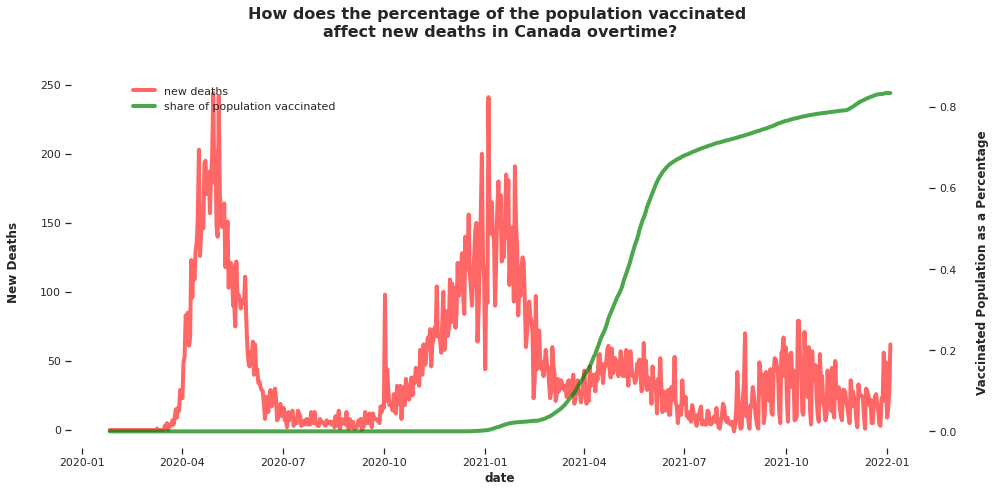

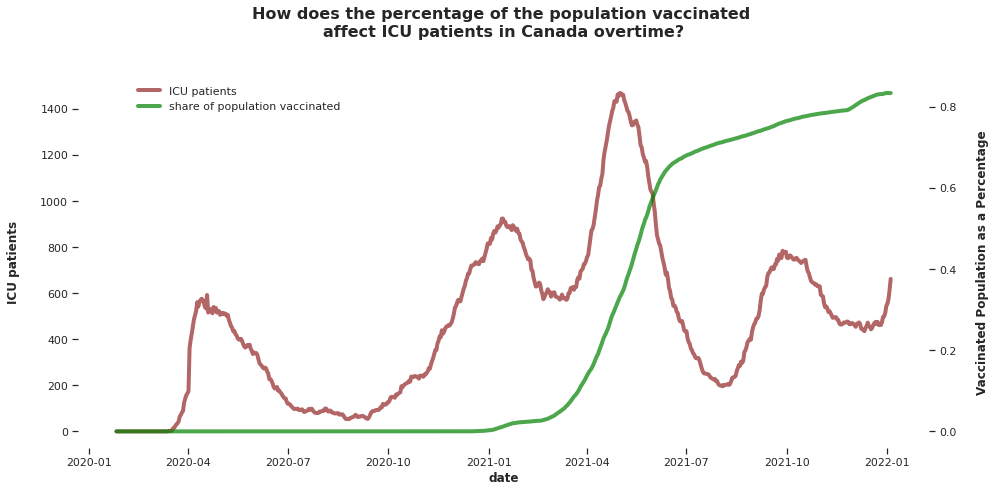

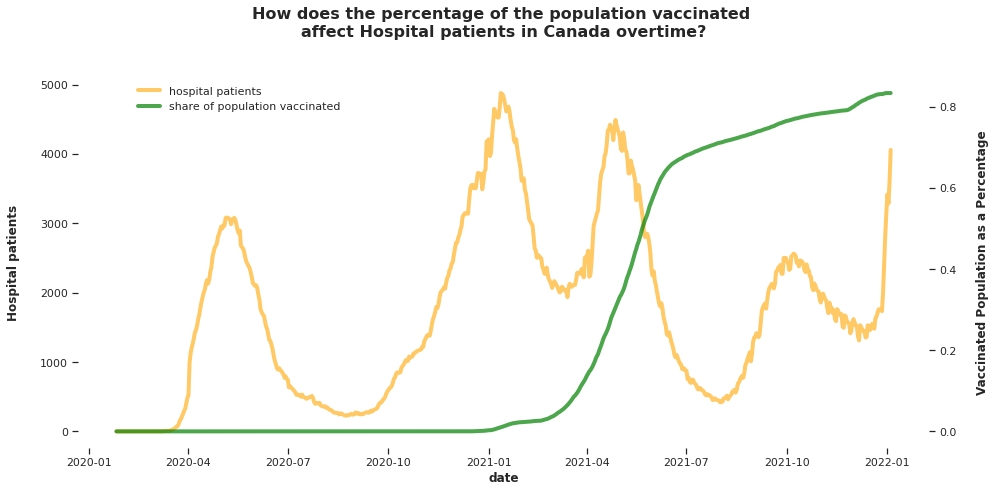

In [ ]:
#New deaths time series
sns.set_theme(style='ticks')
sns.set_context('notebook')

fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111)
ax.plot(Canada_covid.date, Canada_covid.new_deaths, 'red', label = 'new deaths', linewidth = 4, alpha= 0.6)

ax2 = ax.twinx()
ax2.plot(Canada_covid.date, Canada_covid.percent_population_vaccinated, 'green', label = 'share of population vaccinated',linewidth = 4, alpha= 0.7)

ax.set_xlabel('date')
ax.set_ylabel(r'New Deaths', labelpad=20)
ax2.set_ylabel(r'Vaccinated Population as a Percentage', labelpad=20)

ax.axes.set_title('How does the percentage of the population vaccinated \naffect new deaths in Canada overtime?',fontsize=16, weight='bold', pad=40)

sns.despine(left=True, bottom=True)

fig.legend(loc=1, bbox_to_anchor=(0.32,1), bbox_transform=ax.transAxes);



#ICU patients time series
sns.set_theme(style='ticks')
sns.set_context('notebook')

fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111)
ax.plot(Canada_covid.date, Canada_covid.icu_patients, 'maroon', label = 'ICU patients', linewidth = 4, alpha= 0.6)


ax2 = ax.twinx()
ax2.plot(Canada_covid.date, Canada_covid.percent_population_vaccinated, 'green', label = 'share of population vaccinated',linewidth = 4, alpha= 0.7)
ax.set_xlabel('date')
ax.set_ylabel(r'ICU patients', labelpad=20)
ax2.set_ylabel(r'Vaccinated Population as a Percentage', labelpad=20)

ax.axes.set_title('How does the percentage of the population vaccinated \naffect ICU patients in Canada overtime?',fontsize=16, weight='bold', pad=40)

sns.despine(left=True, bottom=True)

fig.legend(loc=1, bbox_to_anchor=(0.32,1), bbox_transform=ax.transAxes);

#Hospital patients time series
sns.set_theme(style='ticks')
sns.set_context('notebook')

fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111)
ax.plot(Canada_covid.date, Canada_covid.hosp_patients, 'orange', label = 'hospital patients', linewidth = 4, alpha= 0.6)


ax2 = ax.twinx()
ax2.plot(Canada_covid.date, Canada_covid.percent_population_vaccinated, 'green', label = 'share of population vaccinated',linewidth = 4, alpha= 0.7)
ax.set_xlabel('date')
ax.set_ylabel(r'Hospital patients', labelpad=20)
ax2.set_ylabel(r'Vaccinated Population as a Percentage', labelpad=20)

ax.axes.set_title('How does the percentage of the population vaccinated \naffect Hospital patients in Canada overtime?',fontsize=16, weight='bold', pad=40)

sns.despine(left=True, bottom=True)

fig.legend(loc=1, bbox_to_anchor=(0.32,1), bbox_transform=ax.transAxes);

**Insight 4**

Although there are high and low number changes in the data following the implementation of the vaccine program, the overall trend is still *downward*, particularly in terms of **the number of deaths**.

However, as this news points out, we cannot rely solely on vaccines to stop COVID-19. Other safety measures are required.

**Notes**

*At the time this project is being completed in 2021-11-09 (upadated on 2021-11-25), the lowest new case date in Canada is 2021-07-01. Thus, the time frame for the results above are*

* Before 2020-12-14
* Between 2021-12-14 and 2021-07-01
* After 2021-07-01

In [ ]:
#First, we convert the date column to pandas datetime format.
Canada_covid['date'] = pd.to_datetime(Canada_covid['date']).dt.normalize()

In [ ]:
#Moreover, we get today's and tomorrow's date, since they will be useful for future plots.
today = df['date'].iloc[-1]
tomorrow = today + pd.DateOffset(days=1)

Since the data is divided by Country for each day, we create a new dataframe 'df_canada' where we group the rows by the column 'date'to get the total daily data in Canada.


In [ ]:
Canada_covid=Canada_covid.groupby('date').sum()

# **Overview**

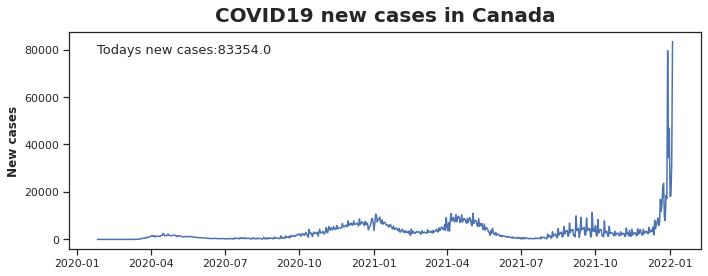

In [ ]:
plt.figure(figsize=(10,4))
plt.title('COVID19 new cases in Canada', fontsize=20)
plt.plot(Canada_covid['new_cases'])
plt.text(Canada_covid.index[0],np.max(Canada_covid['new_cases'])-5000,
         'Todays new cases:{}'.format(Canada_covid['new_cases'].iloc[-1]),
         fontsize=13,
         bbox=dict(facecolor='white', alpha=1))
plt.ylabel('New cases')
plt.show()

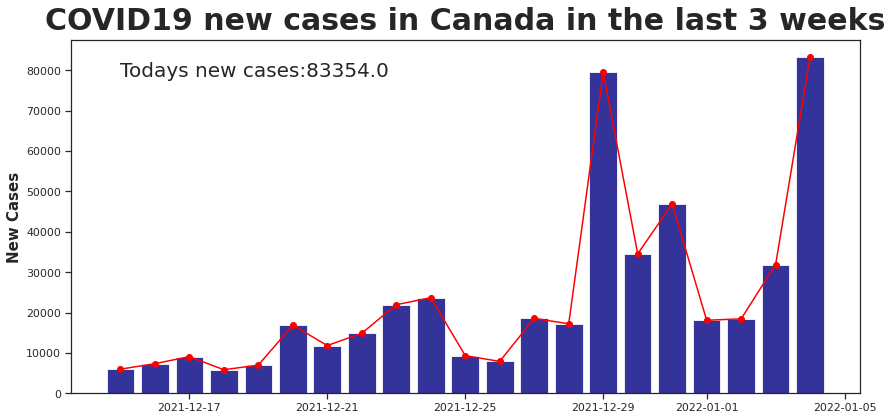

In [ ]:
plt.figure(figsize=(13,6))
plt.title('COVID19 new cases in Canada in the last 3 weeks', fontsize=30)
plt.plot(Canada_covid[-21:].index, Canada_covid[-21:].new_cases, marker='o', color='red')
plt.bar(Canada_covid[-21:].index, Canada_covid[-21:].new_cases, color='#000080', alpha=0.8)
plt.ylabel('New Cases', fontsize=15)
plt.text(Canada_covid[-21:].index[0],np.max(Canada_covid[-21:]['new_cases'])-5000,
         'Todays new cases:{}'.format(Canada_covid['new_cases'].iloc[-1]),
         fontsize=20,
         bbox=dict(facecolor='white', alpha=1))
plt.grid(visible=None, axis='x')
plt.show()

## **Holidays**

In the following, we will define a 'holiday' column to include boolean values to check if a day is a holiday or not. We decided to include this column since, after a first analysis, it looks like that on days after holidays the number of new cases decreases, since on holidays usually less PCR tests are performed. By specifing this information to the prediction models, we can obtain a more accurate forecast.

We create a list comprehension to extract the holidays from the holidays library, and add bolean values to a list is_holiday depending if the date is a holiday (value=1) or not (value=0).

In [ ]:
is_holiday = [1 if x==True else 0 for x in [day in holidays.Canada() for day in Canada_covid.index]]

In [ ]:
Canada_covid['holiday'] = is_holiday

##**Weekly case distribution analysis**

Next we will analyze the weekly distribution to check how the mean, median and standard deviation of new cases changed during the weeks.
First, we create a list of the days for each date.



In [ ]:
day = [calendar.[day.weekday()] for day in Canada_covid.index]

Then we create a new column in the dataframe to host this list.

In [ ]:
Canada_covid['day'] = day

Now we need to create a function that select only the last 4 weeks in the dataframe. We decided to create a new dataframe 'df_canada_small' and assign it the last 34 rows of the dataframe 'df_canada'. Then we check if the current day, and in case it is a Sunday then we can copy 28 rows (4 weeks) of data and assign to a new dataframe 'df_4weeks'

In [ ]:
idx=0 #index to move along the rows
df_4weeks = pd.DataFrame() 
Canada_covid_small = Canada_covid.iloc[-34:].iloc[::-1] #consider 34 rows (worst case)

while(True):
    if Canada_covid_small.iloc[idx:].day[0] == 'Sunday':
        df_4weeks=Canada_covid_small.iloc[:28]
        break
    else:
        idx+=1

Then we extract the 4 values for the 4 weeks, and add a column to indicate the week.

In [ ]:
df_week1=df_4weeks.iloc[:7]
df_week1['week']='1 week ago'

df_week2=df_4weeks.iloc[7:14]
df_week2['week']='2 weeks ago'

df_week3=df_4weeks.iloc[14:21]
df_week3['week']='3 weeks ago'

df_week4=df_4weeks.iloc[21:28]
df_week4['week']='4 weeks ago'

df_4weeks_2 = pd.concat([df_week1, df_week2, df_week3, df_week4])

We extract also the mean, median and standard deviation of the cases during these weeks.

In [ ]:
mean_1 = np.round(df_week1.new_cases.mean(),0)
median_1 = np.round(df_week1.new_cases.median(),0)
std_1 = np.round(df_week1.new_cases.std(),0)

mean_2 = np.round(df_week2.new_cases.mean(),0)
median_2 = np.round(df_week2.new_cases.median(),0)
std_2 = np.round(df_week2.new_cases.std(),0)

mean_3 = np.round(df_week3.new_cases.mean(),0)
median_3 = np.round(df_week3.new_cases.median(),0)
std_3 = np.round(df_week3.new_cases.std(),0)

mean_4 = np.round(df_week4.new_cases.mean(),0)
median_4 = np.round(df_week4.new_cases.median(),0)
std_4 = np.round(df_week4.new_cases.std(),0)

And create ad additional dataframe where we include the week and the three statistics.

In [ ]:
df_stats = pd.DataFrame({'week':['1 week ago','2 weeks ago','3 weeks ago','4 weeks ago'],
                         'mean':[mean_1,mean_2,mean_3,mean_4],
                         'median':[median_1,median_2,median_3,median_4],
                         'std':[std_1,std_2,std_3,std_4]})

In [ ]:
df_stats

,week,mean,median,std
0,1 week ago,"44,667.00","34,523.00","27,014.00"
1,2 weeks ago,"16,207.00","17,205.00","5,962.00"
2,3 weeks ago,"9,128.00","7,335.00","3,999.00"
3,4 weeks ago,"4,366.00","4,002.00","1,939.00"


We can clearly see an increase in Mean, Median and Standard Deviation during the last 4 weeks.
In particular, we can also notice that all these 3 statistics increased more during last week compared to 2 and 3 weeks ago.

# **Time series modeling and Forecasting**

In [ ]:
df = Canada_covid.copy()

In [ ]:
df = df[['new_cases','holiday']]

In [ ]:
df.head()

,new_cases,holiday
date,,
2020-01-26,1.00,0
2020-01-27,0.00,0
2020-01-28,1.00,0
2020-01-29,0.00,0
2020-01-30,0.00,0


Moreover, we also define some time windows which will be useful during the forecasting analysis and plotting.

In [ ]:
prediction_window = 21 #testing window (3 weeks of data)
forecast_window = 7 # forecasting window (1 week)
window = prediction_window + forecast_window #prediction + forecasting window

##**Prophet**

In [ ]:
df_p = df['new_cases'].reset_index().copy()
df_p = df_p.rename(columns={'date': 'ds', 'new_cases': 'y'})

Now we can define the Prophet model.

In [ ]:
prophet_model = Prophet(n_changepoints=50, # hyperpa}rameter
                        seasonality_mode='multiplicative',
                        changepoint_prior_scale=1) # hyperparameter

We add both weekly and yearly seasonality.

In [ ]:
prophet_model.add_seasonality('weekly', period = 7, fourier_order = 10, mode = 'multiplicative')
prophet_model.add_seasonality('yearly', period = 365, fourier_order = 30, mode = 'multiplicative')

Since we cannot add the holiday column as we defined previously, we add the holidays using the 'add_country_holidays()' method of the prophet model class.

In [ ]:
prophet_model.add_country_holidays(country_name='Canada')

In [ ]:
prophet_model.fit(df_p)

INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## **Prophet Forecasting**

In [ ]:
future = prophet_model.make_future_dataframe(periods=forecast_window)

Then we call the 'predict()' method of the prophet model, where we specify the dataframe with future days 'future'

In [ ]:
forecast = prophet_model.predict(future)

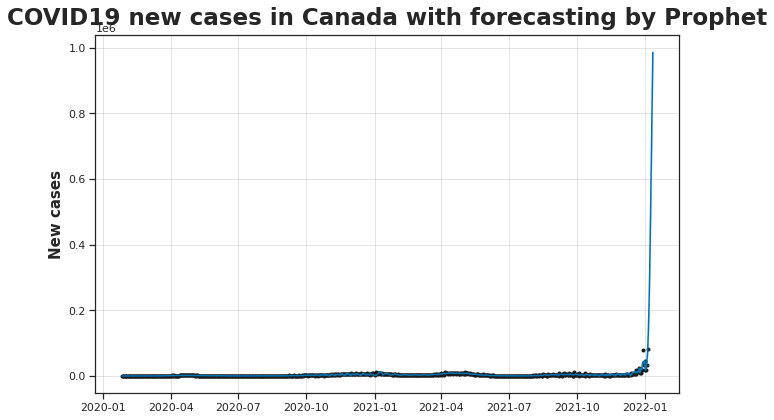

In [ ]:
prophet_model.plot(forecast);
plt.title("COVID19 new cases in Canada with forecasting by Prophet", fontsize=23)
plt.ylabel("New cases", fontsize=15)
plt.xlabel('')
plt.show()

**At a first glance, we can see that the predicted time series (in blue) fits well the original data (black dots).**

Moreover, it could be interesting to see the components (the trend for example) of the predicted time series by calling the 'plot_components()' method of the prophet model.

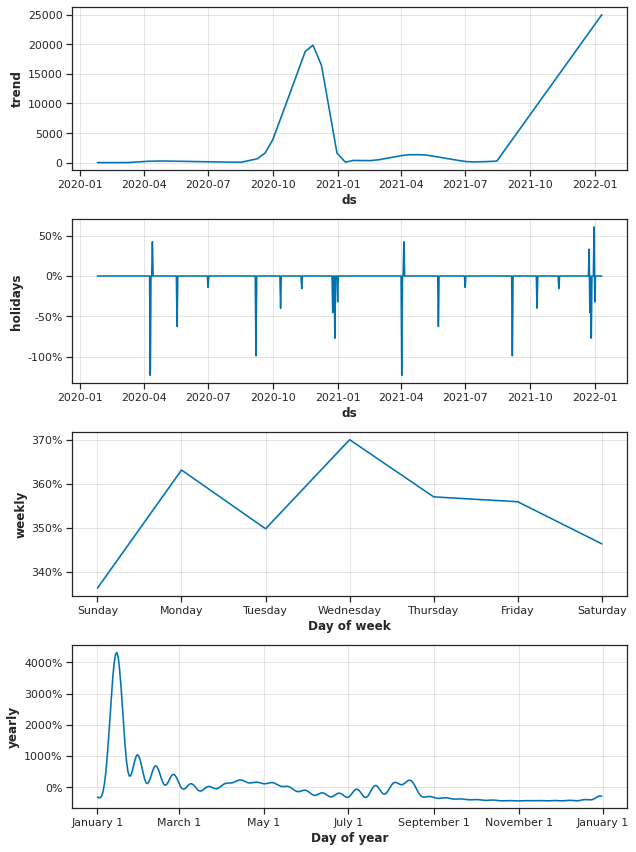

In [ ]:
fig = prophet_model.plot_components(forecast)

Plots analysis:

* Trend: We can see the trends of the 5 covid waves: the steeper one is around October 2020.
* Holidays: We can see the effects of holidays on the number of new cases.
* Weekly seasonality: We can observe the drop of cases on Monday, since on Sunday less tests are carried, and an overall increase over the week, with the highest number of positive cases found around Friday.
* Yearly seasonality: We can observe the drop in cases from May to November, seen both in 2020 and 2021

Next, we want to make a custom plot to check the forecasted days. We first create a dataframe including the dates (ds), predicted values (yhat) and confidence intervals( yhat_lower and yhat_upper).

In [ ]:
forecast_df = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [ ]:
forecast_df

,ds,yhat,yhat_lower,yhat_upper
0,2020-01-26,5.76,"-2,944.75","2,834.36"
1,2020-01-27,4.07,"-2,710.00","3,050.93"
2,2020-01-28,1.22,"-2,800.05","3,138.72"
3,2020-01-29,-2.48,"-2,856.18","3,001.80"
4,2020-01-30,-6.45,"-2,823.67","3,033.46"
...,...,...,...,...
712,2022-01-07,"345,592.78","342,742.49","348,586.90"
713,2022-01-08,"491,700.02","488,445.00","494,998.37"
714,2022-01-09,"655,284.92","651,625.08","658,953.58"
715,2022-01-10,"831,791.28","827,745.95","835,786.91"


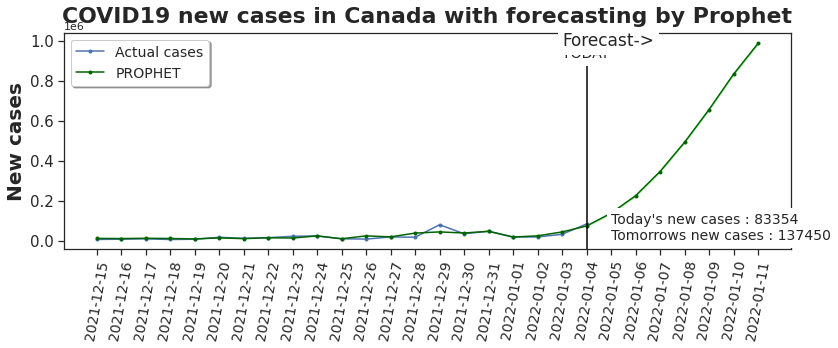

In [ ]:
plt.figure(figsize=(12,5))
plt.title('COVID19 new cases in Canada with forecasting by Prophet', fontsize=22)
#Actual cases
plt.plot(df[-prediction_window:].index, df[-prediction_window:]['new_cases'], label='Actual cases', marker='.')

#PROPHET
plt.plot(forecast_df[-window:]['ds'],forecast_df[-window:]['yhat'],color='#006400',label='PROPHET', marker='.')
plt.fill_between(forecast_df[-forecast_window-1:]['ds'], forecast_df[-forecast_window-1:]['yhat_lower'],forecast_df[-forecast_window-1:]['yhat_upper'], color='lightgreen', alpha=0.5)


text = 'Today\'s new cases : {:.0f}\nTomorrows new cases : {:.0f}'.format(float(df['new_cases'][-1:]), forecast_df[forecast_df['ds']==str(today+ pd.DateOffset(days=1))]['yhat'].values[0])
plt.text(today + pd.DateOffset(days=1), np.min(df[-prediction_window:]['new_cases']), text, bbox=dict(facecolor='white', alpha=1), fontsize=14)


plt.axvline(today, linewidth=1.5, color='black')

plt.text(today - pd.DateOffset(days=1), np.max(forecast_df.iloc[-forecast_window:]['yhat'])-70000, 'TODAY', bbox=dict(facecolor='white', alpha=1), fontsize=14)
plt.text(today- pd.DateOffset(days=1), np.max(forecast_df.iloc[-forecast_window:]['yhat'])-10000, 'Forecast->', bbox=dict(facecolor='white', alpha=1),fontsize=17)

plt.legend(loc='upper left', fontsize=14, fancybox=True, shadow=True, frameon=True)
plt.ylabel('New cases', fontsize=20)
plt.xticks(forecast_df[-prediction_window-forecast_window:]['ds'], rotation=80, fontsize=14)
plt.yticks(fontsize=15)

plt.grid(visible=None, axis='x')
plt.show()

In [ ]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
mape_prophet = mape(forecast_df[-forecast_window-prediction_window:-forecast_window]['yhat'],df_p[-prediction_window:]['y'])
rmse_prophet = mean_squared_error(forecast_df[-forecast_window-prediction_window:-forecast_window]['yhat'],df_p[-prediction_window:]['y'], squared=False)

print('PROPHET RMSE: {:.0f} Cases'.format(rmse_prophet))
print('PROPHET MAPE: {:.1f} %'.format(mape_prophet))

PROPHET RMSE: 10725 Cases
PROPHET MAPE: 26.7 %


**We can see a good fit of the Prophet model on the time series referring to the last 3 weeks.
We can also notice a steep decrease of cases on december 26th and 27th since both 25th and 26th are holidays, so usually less tests are performed. Indeed, the following days result to have lots of new cases.**

## **Neural Prophet**

In [ ]:
m = NeuralProphet(
    n_forecasts=forecast_window, #we forecast one week of data
    n_lags=forecast_window,
    n_changepoints=60, # tuning parameter
    yearly_seasonality=False, # FALSE: we add a custom yearly seasonality
    weekly_seasonality=False, # FALSE: we add a custom weekly seasonality
    daily_seasonality=False, #Since it is daily data there is no daily seasonality
    epochs=200,
    learning_rate=1.0, # tuning parameter
)

In [ ]:
m.add_seasonality('weekly_custom', period = 7, fourier_order = 3)
m.add_seasonality('yearly_custom', period = 365, fourier_order = 20)

In [ ]:
m.add_country_holidays(country_name='Canada')

In [ ]:
metrics = m.fit(df_p, freq="D")

INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO:NP.config:Auto-set batch_size to 16
Epoch[200/200]: 100%|██████████| 200/200 [00:25<00:00,  7.90it/s, SmoothL1Loss=0.0154, MAE=678, RMSE=1.64e+3, RegLoss=0]


## **Neural Prophet Forecasting**

In [ ]:
future = m.make_future_dataframe(df_p, periods=7, n_historic_predictions=len(df_p))
forecast_df_nn = m.predict(future)

WARNING - (NP.forecaster._make_future_dataframe) - Insufficient data for 710 historic forecasts, reduced to 703.


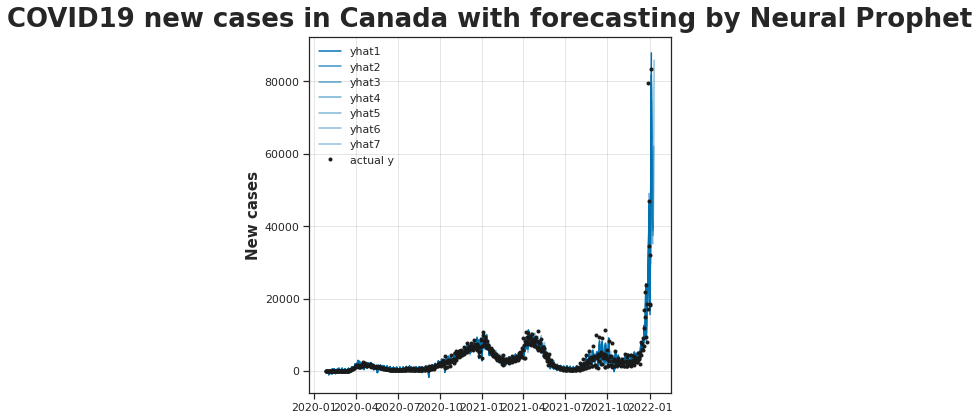

In [ ]:
forecast_plot = m.plot(forecast_df_nn)
plt.title("COVID19 new cases in Canada with forecasting by Neural Prophet", fontsize=26)
plt.xlabel("")
plt.ylabel("New cases", fontsize=15)
plt.show()

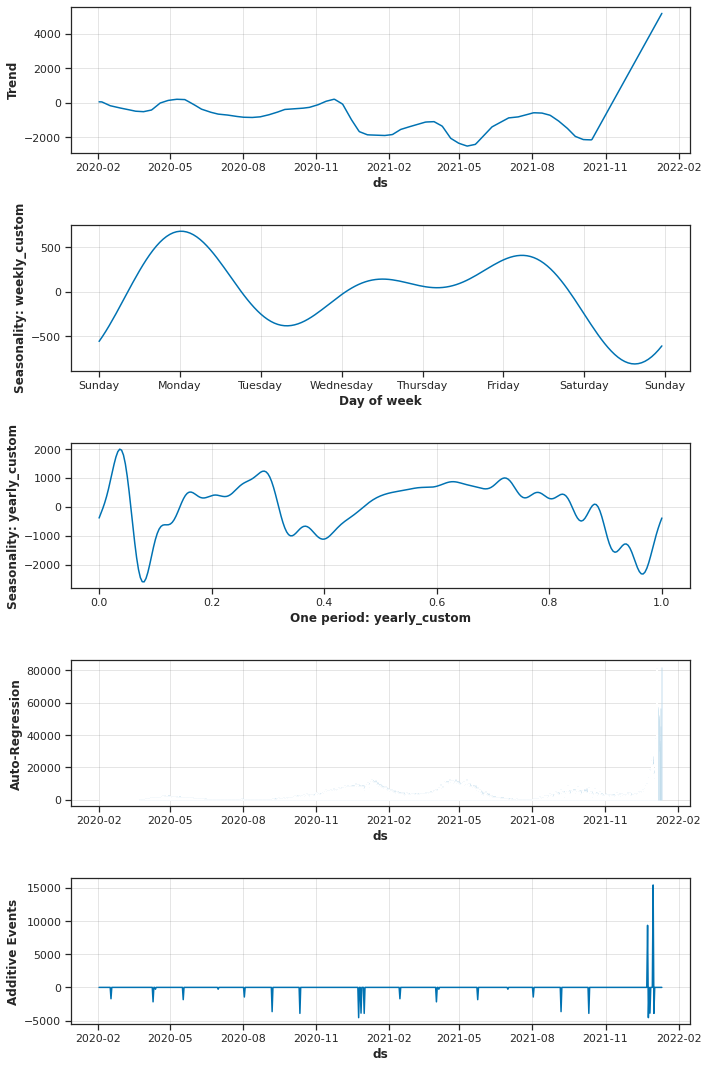

In [ ]:
fig2 = m.plot_components(forecast_df_nn)

The components are comparable to those obtained using Prophet.

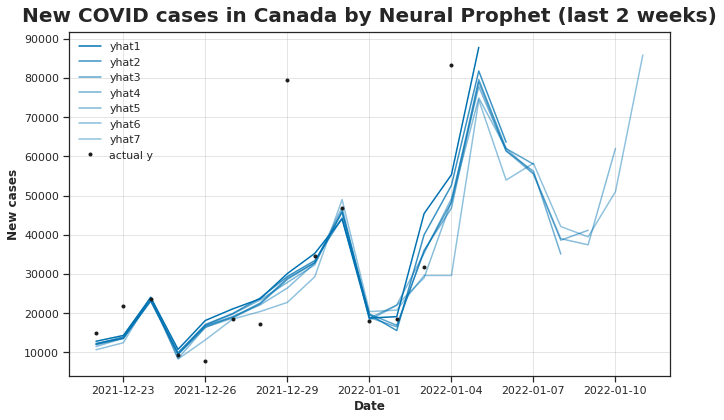

In [ ]:
forecast_plot = m.plot(forecast_df_nn.iloc[-prediction_window:])
plt.title("New COVID cases in Canada by Neural Prophet (last 2 weeks)", fontsize=20)
plt.xlabel("Date")
plt.ylabel("New cases")
plt.show()

**We can see that there are 7 different yhat prediction columns as a consequence of the chosen n_lags parameter.**

In [ ]:
for i in range(7):
    col = 'yhat' + str(i+1)
    mape_test = mape(forecast_df_nn.iloc[-window:-forecast_window][col],df_p.iloc[-prediction_window:]['y'])
    rmse_test = mean_squared_error(forecast_df_nn.iloc[-window:-forecast_window][col],df_p.iloc[-prediction_window:]['y'], squared=False)
    print('PROPHET RMSE {}: {:.0f} Cases'.format(i+1,rmse_test))
    print('PROPHET MAPE {}: {:.1f} %'.format(i+1,mape_test))

PROPHET RMSE 1: 13225 Cases
PROPHET MAPE 1: 27.2 %
PROPHET RMSE 2: 13435 Cases
PROPHET MAPE 2: 28.5 %
PROPHET RMSE 3: 13880 Cases
PROPHET MAPE 3: 28.0 %
PROPHET RMSE 4: 14099 Cases
PROPHET MAPE 4: 28.4 %
PROPHET RMSE 5: 13978 Cases
PROPHET MAPE 5: 28.3 %
PROPHET RMSE 6: 14266 Cases
PROPHET MAPE 6: 29.0 %
PROPHET RMSE 7: 17388 Cases
PROPHET MAPE 7: 38.5 %


We will create a new 'yhat_avg' column to host an average prediction of the 7 'yhat' values.

In [ ]:
forecast_df_nn['yhat_avg'] = forecast_df_nn[['yhat1', 'yhat2', 'yhat3', 'yhat4', 'yhat5', 'yhat6', 'yhat7']].mean(axis=1)

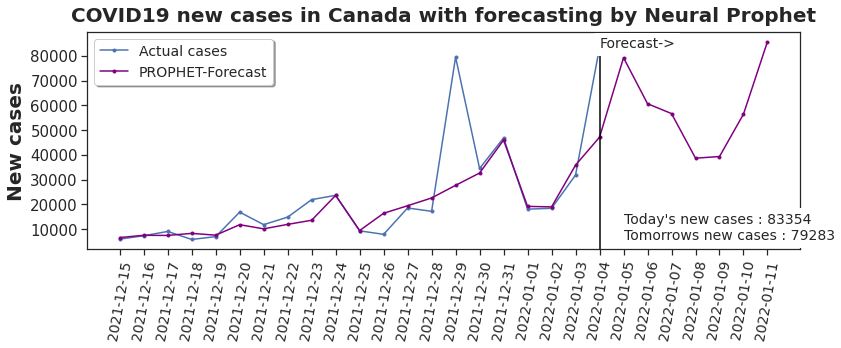

In [ ]:
plt.figure(figsize=(12,5))
plt.title('COVID19 new cases in Canada with forecasting by Neural Prophet', fontsize=20)

#Actual cases
plt.plot(df[-prediction_window:].index, df[-prediction_window:]['new_cases'], label='Actual cases', marker='.')

#Neural Prophet predicted cases
plt.plot(forecast_df_nn[-window:]['ds'],forecast_df_nn[-window:]['yhat_avg'],color='purple',label='PROPHET-Forecast', marker='.')

text = 'Today\'s new cases : {:.0f}\nTomorrows new cases : {:.0f}'.format(float(df['new_cases'][-1:]), forecast_df_nn[forecast_df['ds']==str(today+ pd.DateOffset(days=1))]['yhat_avg'].values[0])
plt.text(today + pd.DateOffset(days=1), np.min(df[-prediction_window:]['new_cases']), text, bbox=dict(facecolor='white', alpha=1), fontsize=14)

plt.axvline(today, linewidth=1.5, color='black')


plt.text(today, np.max(forecast_df_nn[-prediction_window:]['yhat_avg'])-2500, 'Forecast->', bbox=dict(facecolor='white', alpha=1),fontsize=14)

plt.legend(loc='upper left', fontsize=14, fancybox=True, shadow=True, frameon=True)
plt.ylabel('New cases', fontsize=20)
plt.xticks(forecast_df[-prediction_window-forecast_window:]['ds'], rotation=80, fontsize=14)
plt.yticks(fontsize=15)

plt.grid(visible=None, axis='x')
plt.show()

In [ ]:
mape_prophet_nn = mape(forecast_df_nn.iloc[-window:-forecast_window]['yhat_avg'],df_p.iloc[-prediction_window:]['y'])
rmse_prophet_nn = mean_squared_error(forecast_df_nn.iloc[-window:-forecast_window]['yhat_avg'],df_p.iloc[-prediction_window:]['y'], squared=False)
print('PROPHET RMSE : {:.0f} Cases'.format(rmse_prophet_nn))
print('PROPHET MAPE : {:.1f} %:'.format(mape_prophet_nn))

PROPHET RMSE : 14200 Cases
PROPHET MAPE : 28.1 %:


Overall, the forecasted new cases are lower compared to those of Prophet.
We can also notice that the number of predicted cases decrease a lot after the 25th and 26th of December, since both days are holidays.

### **SARIMAX**

**The third model we will develop is a SARIMAX model.**
Before starting the modeling, we first check the time series' stationarity performing the Augmented Dickey Fuller test (ADF), also to understand the best value for the D parameter of the model (integrative term).

In [ ]:
result=adfuller(df['new_cases'].dropna())
print(f'ADF Statistics:{result[0]}')
print(f'p-value:{result[1]}')

ADF Statistics:1.26595059539207
p-value:0.9964113171537072


The p-value is higher than 0.05. This means that the time serie is non stationary with a confidence of 95%. Next we will check if with a one step differentiation, the time serie become stationary (in terms of a trendless time series).

In [ ]:
result=adfuller(df['new_cases'].diff().dropna())
print(f'ADF Statistics:{result[0]}')
print(f'p-value:{result[1]}')

ADF Statistics:6.0800469092134035
p-value:1.0


After a 1-order difference the p-value is still not lower than 0.05.

In [ ]:
result=adfuller(df['new_cases'].diff().diff().dropna())
print(f'ADF Statistics:{result[0]}')
print(f'p-value:{result[1]}')

ADF Statistics:0.01740246669256603
p-value:0.9599478133901692


After a 2-order difference, the p value is stil not lower than 0.05. We should choose a value of d higher than 2 so.
EDIT: by letting auto arima choose the d parameters, the algorithm chooses d=2.

**ACF AND PACF**

To have a better idea of possible the autoregressive parameter (p) and moving average parameter (q) of the SARIMAX model, we can check the auto-correlation function (ACF) and partial auto-correlation function (PACF).



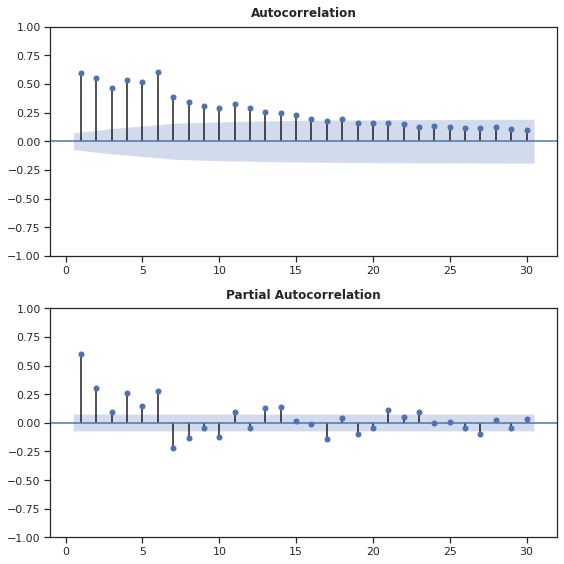

In [ ]:
fig, (ax1, ax2)=plt.subplots(2,1,figsize=(8,8))

plot_acf(df['new_cases'],lags=30, zero=False, ax=ax1)
plot_pacf(df['new_cases'],lags=30, zero=False, ax=ax2)
plt.show()

The series looks indeed non stationary from these plots, and we cannot easily identify good values of p and q.
For this reason we will use the convenient auto arima module to find good parameters for the sarimax model.

**AUTO ARIMA**

In [ ]:
results=pm.auto_arima(df['new_cases'], start_p=0, d=None, start_q=0, max_p=3, max_q=3,
                      seasonal=True, m=7, D=None, test='adf', start_P=0, start_Q=0, max_P=3, max_Q=3,
                      information_criterion='bic', trace=True, error_action='ignore',
                      trend=None, exog=df['holiday'],with_intercept=False, stepwise=True)

Performing stepwise search to minimize bic
 ARIMA(0,1,0)(0,1,0)[7]             : BIC=13658.769, Time=0.10 sec
 ARIMA(1,1,0)(1,1,0)[7]             : BIC=13507.475, Time=0.29 sec
 ARIMA(0,1,1)(0,1,1)[7]             : BIC=13381.895, Time=1.11 sec
 ARIMA(0,1,1)(0,1,0)[7]             : BIC=13375.343, Time=0.47 sec
 ARIMA(0,1,1)(1,1,0)[7]             : BIC=13388.392, Time=0.40 sec
 ARIMA(0,1,1)(1,1,1)[7]             : BIC=13386.514, Time=2.62 sec
 ARIMA(1,1,1)(0,1,0)[7]             : BIC=13384.168, Time=0.23 sec
 ARIMA(0,1,2)(0,1,0)[7]             : BIC=13392.319, Time=0.33 sec
 ARIMA(1,1,0)(0,1,0)[7]             : BIC=13505.695, Time=0.09 sec
 ARIMA(1,1,2)(0,1,0)[7]             : BIC=13288.279, Time=1.09 sec
 ARIMA(1,1,2)(1,1,0)[7]             : BIC=13288.321, Time=2.62 sec
 ARIMA(1,1,2)(0,1,1)[7]             : BIC=13289.746, Time=3.49 sec
 ARIMA(1,1,2)(1,1,1)[7]             : BIC=13315.268, Time=4.68 sec
 ARIMA(2,1,2)(0,1,0)[7]             : BIC=13370.480, Time=2.28 sec
 ARIMA(1,1,3)(0,1,0

In [ ]:
model=SARIMAX(df['new_cases'], order=(1,1,2), seasonal_order=(0,1,0,7), exog = df['holiday'])
results=model.fit()

In [ ]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          new_cases   No. Observations:                  710
Model:             SARIMAX(1, 1, 2)x(0, 1, [], 7)   Log Likelihood               -6649.908
Date:                            Wed, 05 Jan 2022   AIC                          13309.816
Time:                                    08:10:21   BIC                          13332.585
Sample:                                01-26-2020   HQIC                         13318.616
                                     - 01-04-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday    -1540.4836    328.001     -4.697      0.000   -2183.353    -897.614
ar.L1         -1.0000      0.019    -51.728      0.000      -1.038      -0.962
ma.L1          0.0994      0.051      1.967      0.049       0.000       0.198
ma.L2         -0.7037      0.036    -19.364      0.000      -0.775      -0.632
sigma2      9.914e+06      1.016   9.75e+06      0.000    9.91e+06    9.91e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.42   Jarque-Bera (JB):           1669965.49
Prob(Q):                              0.52   Prob(JB):                         0.00
Heteroskedasticity (H):             149.93   Skew:                            13.75
Prob(H) (two-sided):                  0.00   Kurtosis:                       240.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.51e+21. Standard errors may be unstable.
"""

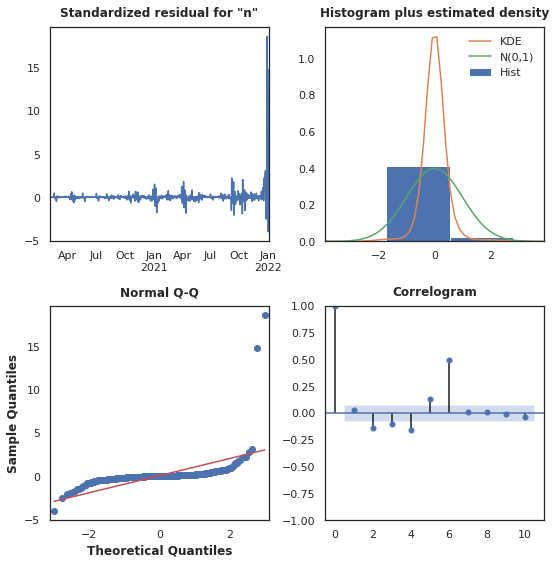

In [ ]:
results.plot_diagnostics(figsize=(8,8))
plt.show()

These plots indicate a good but improvable model. This is probably due to the high variability of the time series among the different waves.
In particular we can see an outlier which degrades the fit: this is probably related to December 26th , when COVID cases dropped from 55k (dec 25th) to 25k.

## **SARIMAX Forecasting**

**SARIMAX Prediction**

Our goal now is to create a dataframe which will host the model test predictions (last 3 weeks of data) and the forecast values (future 7 days).
We start by creating the prediction dataset.

In [ ]:
prediction = results.get_prediction(start=-prediction_window, exog = df['holiday'])
mean_prediction = prediction.predicted_mean

Moreover, we also get the confidence intervals from the sarimax prediction

In [ ]:
confi_int_p = prediction.conf_int()
lower_limits_p = confi_int_p.iloc[:,0]
upper_limits_p = confi_int_p.iloc[:,1]

Then we create a new dataframe which will include 3 columns: predicted value 'yhat' and the upper and lower values for yhat (confidence interval)



In [ ]:
lower_today = np.full([1, prediction_window], np.nan).flatten() #empty list with length = 21 ( 3 weeks)
upper_today = np.full([1, prediction_window], np.nan).flatten() #empty list with length = 21 ( 3 weeks)

We also define the confidence interval for the prediction of today's new cases: if we dont do so, the following plot will have a 'gap' for the forecast value.

In [ ]:
lower_today[-1] = confi_int_p.iloc[:,0][-1] # lower value for prediction of todays value
upper_today[-1] = confi_int_p.iloc[:,1][-1] # upper value for prediction of todays value

In [ ]:
sarima_prediction = pd.DataFrame({'yhat':mean_prediction, 'y_lower':lower_today,'y_upper': upper_today})

## **SARIMAX FORECAST**

We will create a forecast dataframe similarly how we created the prediction dataframe.

In [ ]:
forecast = results.get_forecast(steps=forecast_window, exog = df['holiday'].iloc[-forecast_window:])
mean_forecast=forecast.predicted_mean

In [ ]:
#Confidence Intervals for forecasting
confi_int_f=forecast.conf_int()
lower_limits_f=confi_int_f.iloc[:,0]
upper_limits_f=confi_int_f.iloc[:,1]

In [ ]:

sarima_forecast = pd.DataFrame({'yhat':mean_forecast, 'y_lower':lower_limits_f,'y_upper':upper_limits_f})

Finally we append the forecast dataframe to the prediction dataframe.

In [ ]:
sarima_results = sarima_prediction.append(sarima_forecast)

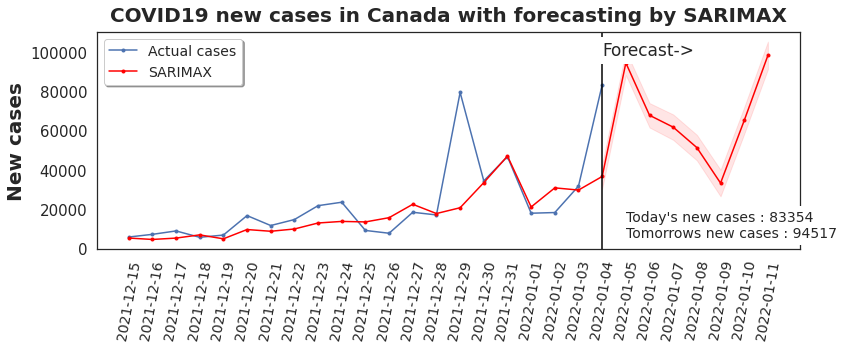

In [ ]:
plt.figure(figsize=(12,5))
plt.title('COVID19 new cases in Canada with forecasting by SARIMAX', fontsize=20)


#Actual cases
plt.plot(df[-prediction_window:].index,df[-prediction_window:]['new_cases'], label='Actual cases', marker='.')

#SARIMA
plt.plot(sarima_results.index, sarima_results.yhat,color='red',label='SARIMAX', marker='.')
plt.fill_between(sarima_results[-forecast_window-1:].index, sarima_results[-forecast_window-1:].y_lower, sarima_results[-forecast_window-1:].y_upper, color='red', alpha=0.1)

text = 'Today\'s new cases : {:.0f}\nTomorrows new cases : {:.0f}'.format(float(df['new_cases'][-1:]),mean_forecast[0])
plt.text(today + pd.DateOffset(days=1), np.min(df[-prediction_window:]['new_cases']), text, bbox=dict(facecolor='white', alpha=1), fontsize=14)


plt.axvline(today, linewidth=1.5, color='black')
plt.text(today, np.max(mean_forecast), 'Forecast->', bbox=dict(facecolor='white', alpha=1),fontsize=17)

plt.legend(loc='upper left', fontsize=14, fancybox=True, shadow=True, frameon=True)
plt.ylabel('New cases', fontsize=20)
plt.xticks(forecast_df[-prediction_window-forecast_window:]['ds'], rotation=80, fontsize=14)
plt.yticks(fontsize=15)
plt.grid(visible=None, axis='x')
plt.show()

In [ ]:
mape_sarima= mape(df[-prediction_window:]['new_cases'], mean_prediction.values)
rmse_sarima = mean_squared_error(df[-prediction_window:]['new_cases'], mean_prediction.values, squared=False)

print('SARIMA RMSE: {:.0f} Cases'.format(rmse_sarima))
print('SARIMA MAPE: {:.1f} %'.format(mape_sarima))

SARIMA RMSE: 17131 Cases
SARIMA MAPE: 33.8 %


**Results Summary**

In [ ]:
pd.DataFrame({'Model':['Prophet','Neural Prophet','SARIMA'],'MAPE': [mape_prophet,mape_prophet_nn,mape_sarima],'RMSE':[rmse_prophet,rmse_prophet_nn,rmse_sarima]}).set_index('Model')

,MAPE,RMSE
Model,,
Prophet,26.68,"10,725.22"
Neural Prophet,28.07,"14,200.34"
SARIMA,33.85,"17,130.91"


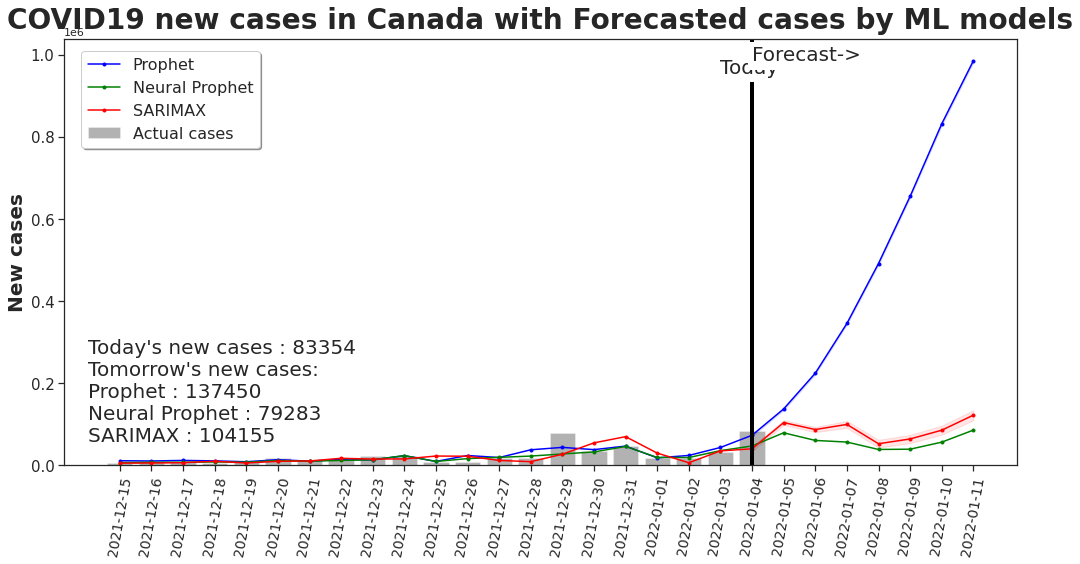

In [ ]:
plt.figure(figsize=(16,8))
plt.title('COVID19 new cases in Canada with Forecasted cases by ML models', fontsize=28)
#Actual cases
plt.bar(df[-prediction_window:].index, df[-prediction_window:]['new_cases'], label='Actual cases', color='black', alpha=0.3)
#PROPHET
plt.plot(forecast_df[-window:]['ds'],forecast_df[-window:]['yhat'],color='blue',label='Prophet', marker='.')
plt.fill_between(forecast_df[-forecast_window-1:]['ds'], forecast_df[-forecast_window-1:]['yhat_lower'],forecast_df[-forecast_window-1:]['yhat_upper'], color='blue', alpha=0.1)

#NEURAL PROPHET
plt.plot(forecast_df_nn[-window:]['ds'],forecast_df_nn[-window:]['yhat_avg'],color='green',label='Neural Prophet', marker='.')

#SARIMA
plt.plot(sarima_results.index, sarima_results.yhat,color='red',label='SARIMAX', marker='.')
plt.fill_between(sarima_results[-forecast_window-1:].index, sarima_results[-forecast_window-1:].y_lower, sarima_results[-forecast_window-1:].y_upper, color='red', alpha=0.1)


text = 'Today\'s new cases : {:.0f}\nTomorrow\'s new cases:\nProphet : {:.0f}\nNeural Prophet : {:.0f}\nSARIMAX : {:.0f}'.format(float(df['new_cases'][-1:]),forecast_df[forecast_df['ds']==str(tomorrow)]['yhat'].values[0],forecast_df_nn[forecast_df_nn['ds']==str(tomorrow)]['yhat_avg'].values[0],mean_forecast[0])
plt.text(today - pd.DateOffset(days=21), np.max(df[-prediction_window:]['new_cases'])-25000, text, bbox=dict(facecolor='white', alpha=1), fontsize=20)

plt.axvline(today, linewidth=4, color='black')
plt.text(today - pd.DateOffset(days=1), np.max(forecast_df.iloc[-forecast_window:]['yhat'])-30000, 'Today', bbox=dict(facecolor='white', alpha=1), fontsize=20)
plt.text(today , np.max(forecast_df.iloc[-forecast_window:]['yhat']), 'Forecast->', bbox=dict(facecolor='white', alpha=1),fontsize=20)
plt.legend(loc='upper left', fontsize=16, bbox_to_anchor=(0.01, 0.99), fancybox=True, shadow=True, frameon=True)
plt.ylabel('New cases', fontsize=20)
plt.xticks(forecast_df[-prediction_window-forecast_window:]['ds'], rotation=80, fontsize=14)
plt.yticks(fontsize=15)
plt.grid(visible=None, axis='x')

plt.show()

In [ ]:
print('Today\'s new cases : {:.0f}'.format(float(df['new_cases'][-1:])))
print('Tomorrows new cases according to SARIMAX : {:.0f}'.format(mean_forecast[0]))
print('Tomorrows new cases according to PROPHET : {:.0f}'.format(forecast_df[forecast_df['ds']==str(tomorrow)]['yhat'].values[0]))
print('Tomorrows new cases according to Neural PROPHET : {:.0f}'.format(forecast_df_nn[forecast_df_nn['ds']==str(tomorrow)]['yhat_avg'].values[0]))

Today's new cases : 83354
Tomorrows new cases according to SARIMAX : 104155
Tomorrows new cases according to PROPHET : 137450
Tomorrows new cases according to Neural PROPHET : 79283


**Overall, we can see that Neural Prophet and SARIMAX predict and forecast similar values, which are lower compared to those predicted and forecasted by Prophet.**

Finally, we will create a final dataframe that will host the average prediction among the three models.

In [ ]:
df_final = pd.DataFrame({'date':forecast_df_nn[-window:]['ds'], 'y_p':forecast_df[-window:]['yhat'], 'y_p_nn':forecast_df_nn[-window:]['yhat_avg'], 'y_s':sarima_results['yhat'].values})

In [ ]:
df_final = df_final.set_index('date')

In [ ]:
df_final['y_avg'] = df_final.mean(axis=1)

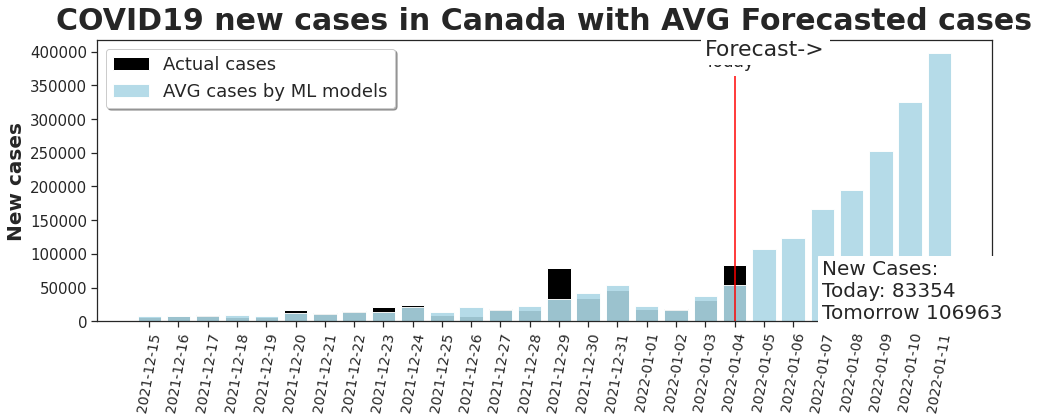

In [ ]:
plt.figure(figsize=(15,6))
plt.title('COVID19 new cases in Canada with AVG Forecasted cases', fontsize=30)
#Actual cases
plt.bar(df[-prediction_window:].index, df[-prediction_window:]['new_cases'], label='Actual cases', color='black',alpha=1)

#AVG Forecast
plt.bar(df_final.index, df_final.y_avg,label='AVG cases by ML models', color='lightblue',alpha=0.9)

text = 'New Cases:\nToday: {:.0f}\nTomorrow {:.0f}'.format(float(df['new_cases'][-1:]),df_final[-forecast_window:]['y_avg'].values[0])
plt.text(today + pd.DateOffset(days=3), 4000, text, bbox=dict(facecolor='white', alpha=1), fontsize=20)

plt.axvline(today, linewidth=1.5, color='red')
plt.text(today - pd.DateOffset(days=1), np.max(df_final['y_avg'])-20000, 'Today', bbox=dict(facecolor='white', alpha=1), fontsize=17)
plt.text(today - pd.DateOffset(days=1), np.max(df_final['y_avg'])-4000, 'Forecast->', bbox=dict(facecolor='white', alpha=1),fontsize=22)
plt.legend(loc='upper left', fontsize=18,  fancybox=True, shadow=True, frameon=True)
plt.ylabel('New cases', fontsize=20)
plt.xticks(forecast_df[-prediction_window-forecast_window:]['ds'], rotation=80, fontsize=14)
plt.yticks(fontsize=15)
plt.grid(visible=None, axis='x')

plt.show()